In this notebook, we will walk through a solution to optimize ride-hailing demand prediction and guide drivers to zones with higher expected demand. The notebook includes the following steps:

- **Loading and exploring the data**
- **Determining the optimal number of zones using the Elbow Method and Silhouette Score**
- **Clustering the city into zones**
- **Visualizing the zones and their centers**
- **Aggregating historical demand and ride value data**
- **Recommending the best zones for drivers based on proximity and demand**

In [2]:
import pandas as pd

# Load the ride-hailing data
filepath = "data/robotex5.csv"
df = pd.read_csv(filepath)

# Convert 'start_time' to datetime format
df["start_time"] = pd.to_datetime(df["start_time"])

# Sort by 'start_time'
df = df.sort_values("start_time")

# Show the first few rows of the dataset
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
589247,2022-03-01 00:00:07.936317,59.438142,24.728677,59.553133,24.802705,3.35200
613394,2022-03-01 00:00:17.556188,59.443230,24.753330,59.391667,24.722047,1.49500
557451,2022-03-01 00:00:20.355945,59.431849,24.768252,59.433692,24.728579,0.55275
266890,2022-03-01 00:00:20.690881,59.439587,24.748874,59.452895,24.871234,1.73725
191825,2022-03-01 00:00:25.804142,59.367751,24.645455,59.396104,24.800205,2.28675


## Determine the Optimal Number of Clusters
We'll use both the Elbow Method and Silhouette Score to find the optimal number of clusters (zones) to divide the city.

For 3 clusters: Inertia=609.6045252438182, Silhouette=0.5307725307941484
For 4 clusters: Inertia=464.14255767016436, Silhouette=0.4246096826215774
For 5 clusters: Inertia=352.1031836806889, Silhouette=0.44525015336981755
For 6 clusters: Inertia=318.4507478509917, Silhouette=0.43150637173225265
For 7 clusters: Inertia=268.12948598569665, Silhouette=0.4068923618664009


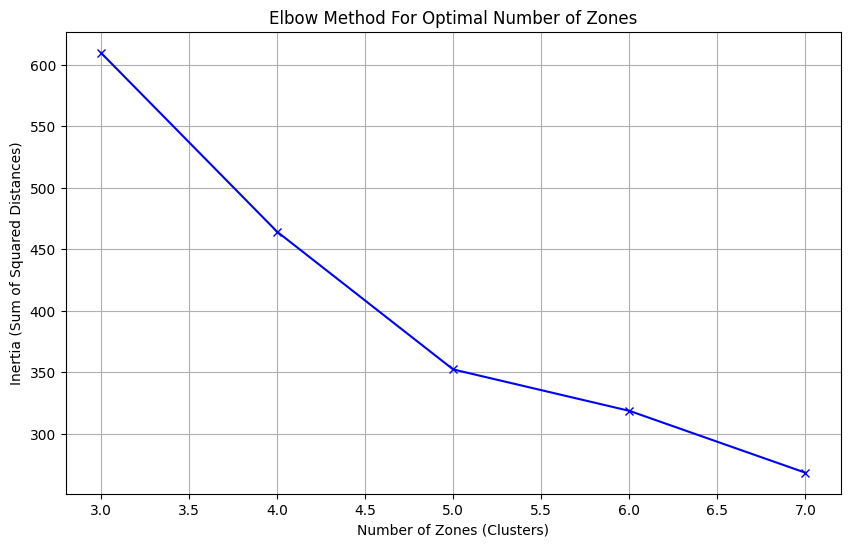

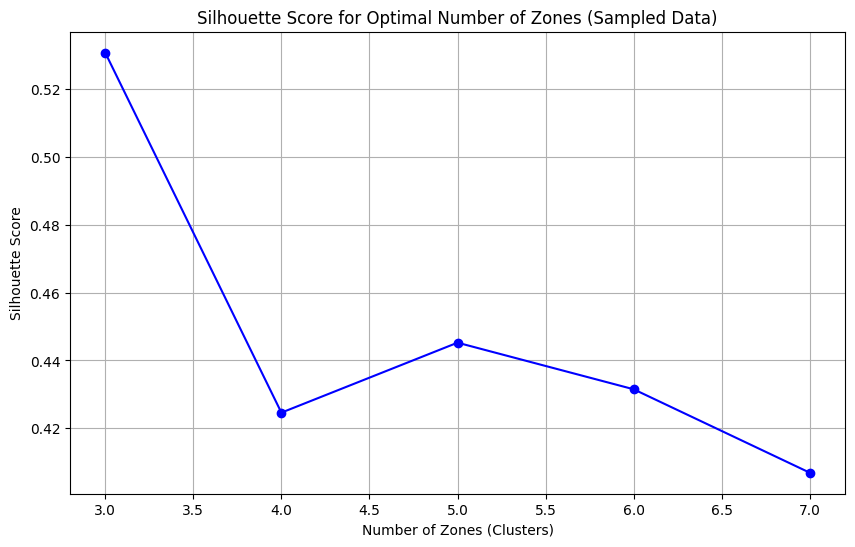

Optimal number of zones (based on Silhouette Score): 3


In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# Extract relevant features for clustering (latitude and longitude)
X = df[["start_lat", "start_lng"]]

# Range of possible cluster numbers (adjust as needed)
cluster_range = range(3, 8)

# Store inertia (sum of squared distances) and silhouette scores for each cluster number
inertia_values = []
silhouette_scores = []

# Define a sample size for silhouette score (use a smaller subset of the data)
sample_size = min(
    50000, len(X)
)  # Use a max of 50,000 points or the dataset size if smaller
X_sample = X.sample(n=sample_size, random_state=42)

# Set to True if you want to use MiniBatchKMeans for large datasets
use_mini_batch = False

# Loop over different cluster numbers
for n_clusters in cluster_range:
    # Perform KMeans or MiniBatchKMeans clustering
    if use_mini_batch:
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters, random_state=42, batch_size=10000
        )
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    cluster_labels = kmeans.fit_predict(X)

    # Calculate inertia (sum of squared distances to the closest centroid)
    inertia_values.append(kmeans.inertia_)

    # Calculate silhouette score on the sampled data
    cluster_labels_sample = kmeans.predict(X_sample)  # Predict labels for the sample
    silhouette_avg = silhouette_score(X_sample, cluster_labels_sample)
    silhouette_scores.append(silhouette_avg)

    print(
        f"For {n_clusters} clusters: Inertia={kmeans.inertia_}, Silhouette={silhouette_avg}"
    )

# Plot the Elbow Method results (Inertia)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, "bx-")
plt.xlabel("Number of Zones (Clusters)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method For Optimal Number of Zones")
plt.grid(True)
plt.show()

# Plot the Silhouette Score results
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, "bo-")
plt.xlabel("Number of Zones (Clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Number of Zones (Sampled Data)")
plt.grid(True)
plt.show()

# Optional: Save the results for further analysis
optimal_zone_data = pd.DataFrame(
    {
        "n_clusters": cluster_range,
        "inertia": inertia_values,
        "silhouette_score": silhouette_scores,
    }
)

optimal_zone_data.to_csv("optimal_zones_analysis.csv", index=False)

# Print the best number of zones according to the silhouette score
optimal_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of zones (based on Silhouette Score): {optimal_n_clusters}")


In [7]:
optimal_zone_data

,n_clusters,inertia,silhouette_score
0,3,609.604525,0.530773
1,4,464.142558,0.424610
2,5,352.103184,0.445250
3,6,318.450748,0.431506
4,7,268.129486,0.406892


Based on the results from the Elbow Method and Silhouette Score plots:

Elbow Method Analysis:
- There is a noticeable bend at 5 clusters (around an inertia of 350). This suggests that adding more clusters beyond 5 provides diminishing returns in reducing the inertia.
- The slope between 5 and 6 clusters flattens, which indicates that 5 clusters could be the optimal number.

Silhouette Score Analysis:
- The silhouette score peaks at 3 clusters, but it drops significantly for 4 clusters.However, the score for 5 clusters shows an improvement over 4 clusters and is higher than the score for 6 and 7 clusters.

Conclusion:
5 clusters seem to be the best compromise, as indicated by both methods:
- The Elbow Method suggests that 5 clusters strike a good balance between minimizing inertia and avoiding unnecessary complexity.
- The Silhouette Score shows that 5 clusters provide a reasonable separation between the data points compared to other options.


## Cluster the City into Zones
Now that we've determined the optimal number of clusters, we'll perform the clustering. We will plot the clusters on a scatter plot to visualize how the city has been divided into zones. With X on the plot we show zone center.

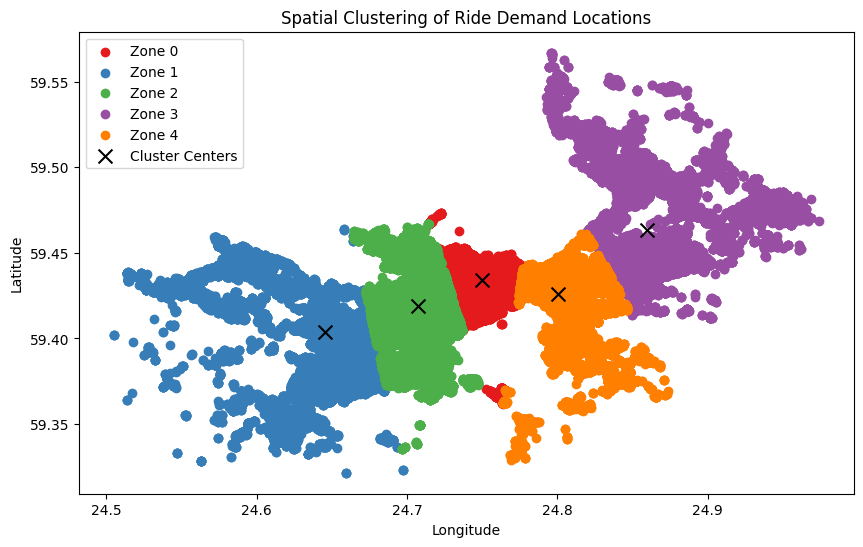

In [4]:
import seaborn as sns

# Use KMeans to cluster 'start_lat' and 'start_lng' into spatial zones
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["zone"] = kmeans.fit_predict(df[["start_lat", "start_lng"]])

# Save the clustered data
df.to_csv("robotex5_clustered.csv", index=False)

# Calculate cluster centers
cluster_centers = kmeans.cluster_centers_

# Assign colors to each zone (you can change colors as needed)
colors = sns.color_palette(
    "Set1", n_clusters
).as_hex()  # 'Set1' provides distinguishable colors
color_map = {i: colors[i] for i in range(n_clusters)}  # Map zone index to color

# Save the clusters and centers to CSV, including color information
cluster_data = pd.DataFrame(cluster_centers, columns=["center_lat", "center_lng"])
cluster_data["zone"] = cluster_data.index
cluster_data["color"] = cluster_data["zone"].map(color_map)  # Add the color mapping

cluster_data.to_csv("cluster_centers.csv", index=False)

# Quick visualization of spatial clusters using consistent colors
plt.figure(figsize=(10, 6))
for zone in range(n_clusters):
    zone_data = df[df["zone"] == zone]
    plt.scatter(
        zone_data["start_lng"],
        zone_data["start_lat"],
        color=color_map[zone],
        label=f"Zone {zone}",
    )

# Plot the cluster centers
plt.scatter(
    cluster_data["center_lng"],
    cluster_data["center_lat"],
    c="black",
    marker="x",
    s=100,
    label="Cluster Centers",
)
plt.title("Spatial Clustering of Ride Demand Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [6]:
cluster_data

,center_lat,center_lng,zone,color
0,59.434232,24.750205,0,#e41a1c
1,59.403594,24.645457,1,#377eb8
2,59.418899,24.707550,2,#4daf4a
3,59.463346,24.859487,3,#984ea3
4,59.425718,24.800651,4,#ff7f00


## Aggregate Historical Data for Demand and Ride Value
Next, we'll aggregate the historical data to calculate the demand (number of rides) and average ride value for each zone by hour and day of the week.

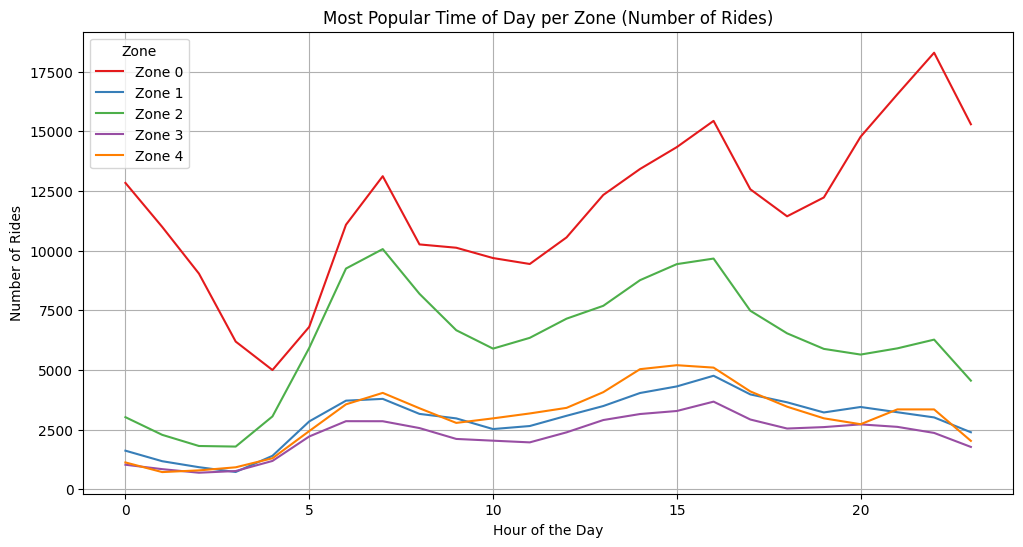

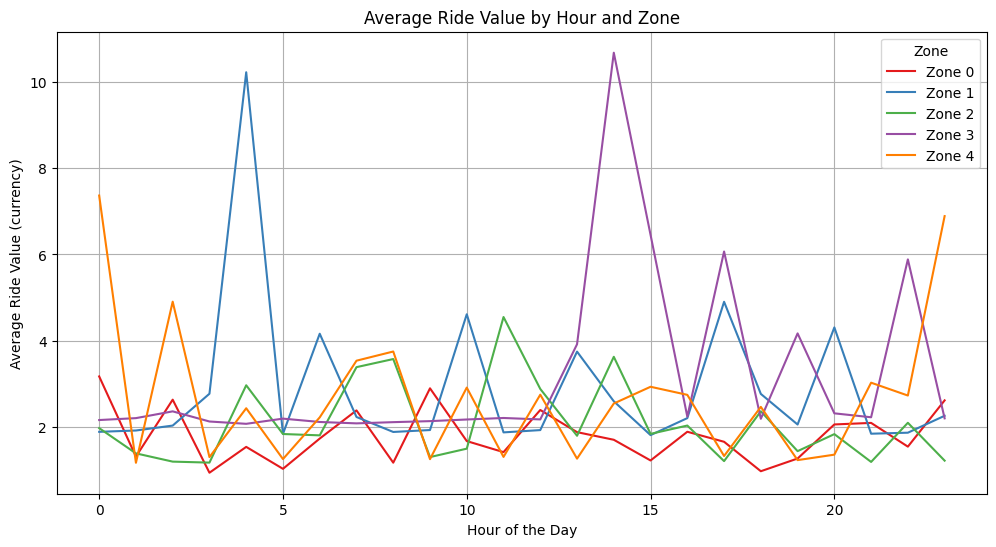

In [5]:
df = pd.read_csv("robotex5_clustered.csv")

# Load the cluster centers with colors
cluster_centers = pd.read_csv("cluster_centers.csv")

# Create a color map from the cluster_centers file
zone_colors = cluster_centers.set_index("zone")["color"].to_dict()

# Extract features from 'start_time'
df["start_time"] = pd.to_datetime(df["start_time"])
df = df.sort_values("start_time")
df["hour"] = df["start_time"].dt.hour
df["day_of_week"] = df["start_time"].dt.dayofweek  # Monday=0, Sunday=6
# df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating the demand data (number of rides) and average ride value for each cluster and hour of the day
aggregated_data = (
    df.groupby(["zone", "hour", "day_of_week"])
    .agg(
        num_rides=("ride_value", "count"),  # Count of rides as a measure of demand
        avg_ride_value=("ride_value", "mean"),  # Average ride value in each group
    )
    .reset_index()
)
aggregated_data.to_csv("aggregated_demand.csv", index=False)

# Aggregating number of rides by zone and hour
rides_by_hour_zone = (
    df.groupby(["zone", "hour"])
    .agg(num_rides=("ride_value", "count"), avg_ride_value=("ride_value", "mean"))
    .reset_index()
)


# Plot 1: Most popular time of day per zone (number of rides by hour)
plt.figure(figsize=(12, 6))
for zone in rides_by_hour_zone["zone"].unique():
    zone_data = rides_by_hour_zone[rides_by_hour_zone["zone"] == zone]
    plt.plot(
        zone_data["hour"],
        zone_data["num_rides"],
        label=f"Zone {zone}",
        color=zone_colors[zone],
    )
plt.title("Most Popular Time of Day per Zone (Number of Rides)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.legend(title="Zone")
plt.grid(True)
plt.savefig("most_popular_time_of_day.png")

# Plot 2: Average ride value by hour and zone
plt.figure(figsize=(12, 6))
for zone in rides_by_hour_zone["zone"].unique():
    zone_data = rides_by_hour_zone[rides_by_hour_zone["zone"] == zone]
    plt.plot(
        zone_data["hour"],
        zone_data["avg_ride_value"],
        label=f"Zone {zone}",
        color=zone_colors[zone],
    )
plt.title("Average Ride Value by Hour and Zone")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Ride Value (currency)")
plt.legend(title="Zone")
plt.grid(True)
plt.savefig("average_ride_value.png")

As we can see from the plots most popular times are similar for all zones - in the morning, lunch and evening. Most popular zone is 0, which I assume is city center. From average order values it is obvious that further zones bring more value.

In [9]:
aggregated_data.head()

,zone,hour,day_of_week,num_rides,avg_ride_value
0,0,0,0,1939,2.628018
1,0,0,1,1878,4.446328
2,0,0,2,1747,2.147888
3,0,0,3,1550,4.435791
4,0,0,4,1709,5.326186


## Make Zone Recommendations for Drivers
Finally, based on the aggregated demand and ride value data, we can make recommendations for drivers on which zone to target. We'll calculate the score for each zone by considering both the proximity to the driver and the expected demand.

In [10]:
import numpy as np

# Load aggregated data from the historical dataset (already calculated)
# This data contains aggregated number of rides and average ride values for each zone, hour, and day
aggregated_data = pd.read_csv("aggregated_demand.csv")

# Load the cluster centers with colors
cluster_centers = pd.read_csv("cluster_centers.csv")

# Driver's current location (for example)
driver_lat, driver_lng = 59.43, 24.75

# Get current time details (simulating current hour and day of the week)
current_hour = 14
current_day_of_week = 3  # For example, Wednesday

# Filter the historical data for the current hour and day
current_data = aggregated_data[
    (aggregated_data["hour"] == current_hour)
    & (aggregated_data["day_of_week"] == current_day_of_week)
]

# Merge current_data with cluster_centers to get zone locations
current_data = current_data.merge(cluster_centers, on="zone")

# Calculate the distance from the driver to each zone center
current_data["distance"] = np.sqrt(
    (current_data["center_lat"] - driver_lat) ** 2
    + (current_data["center_lng"] - driver_lng) ** 2
)

# Sort zones by demand (num_rides), ride value (avg_ride_value), and distance
# You can use a weighted sum or scoring system based on your preference
current_data["score"] = (
    current_data["num_rides"]
    * current_data["avg_ride_value"]
    / current_data["distance"]
)
sorted_zones = current_data.sort_values(by="score", ascending=False)

# Show the top recommendations
print(sorted_zones[["zone", "num_rides", "avg_ride_value", "distance", "score"]].head())

# Save the sorted zones to a file if needed
sorted_zones.to_csv("recommended_zones.csv", index=False)


   zone  num_rides  avg_ride_value  distance          score
0     0       1955        1.008186  0.004237  465175.112801
3     3        474       20.221101  0.114452   83745.188676
2     2       1308        2.803653  0.043877   83578.004144
4     4        758        3.590605  0.050832   53542.790886
1     1        585        1.725673  0.107827    9362.432386


## P.S.

Since we had only 1 month data, I predict demand with simply taking historical data, which is not much to train model for each day, time and zone. But if we have data for multiple years, where we can take into consideration national Estonian weekends, celebration days, etc. there would be sense for MLP or small NN which will predict order count and avg value each time.

In this case where we are going to take each day new data I would use Naive Bayes or EWMA which will take latest zone order activities. I would also reclusterize each year if city is actively getting bigger and new districts are made.

## Questions from the Task

### Describe how you would design and deploy such a model


Data Pipeline:

A data pipeline would be set up to collect real-time ride data (e.g., pickup locations, ride times, ride values). This data would feed into the demand aggregation module.
The pipeline would also need a mechanism to update the aggregated statistics on a regular schedule (e.g., every hour or once a day).

REST API:

The recommendation system can be deployed as a REST API, which takes the driver’s location and the current time as input and returns a ranked list of zones where demand is expected to be highest.
The API would call the recommendation module to calculate the zone ranking in real-time based on the precomputed aggregated data.

### Describe how to communicate model recommendations to drivers

Real-Time Notifications:

The driver app can push notifications to drivers when the system detects a high-demand zone nearby. This notification would contain:
The zone location (e.g., a nearby hotspot or cluster center).
An estimate of expected earnings (based on the average ride value in that zone).
The estimated distance to that zone.

Visual Heatmap:

The driver app can display a heatmap of the city, where zones with higher expected demand are highlighted. Zones can be color-coded based on the intensity of demand.

The recommendation system should also allow drivers to provide feedback on the suggestions (e.g., thumbs up/down), enabling continuous improvement of recommendations.

### Think through and describe the design of the experiment that would validate your solution for live operations taking into account marketplace specifics

We would design an A/B experiment. This will allow us to measure how well the recommendation system performs in real-world conditions, ensuring that it improves the efficiency of the marketplace without causing unintended consequences.

Experiment Setup:

1. Randomized Driver Group Assignment:

Control Group: This group of drivers will operate without receiving demand-based recommendations. They will choose their next location based on their own judgment.

Treatment Group: This group will receive real-time recommendations from the model, including notifications of high-demand zones and heatmaps.

2. Duration:

The experiment should run for at least 2 to 4 weeks to capture enough variability in demand patterns (e.g., weekday vs. weekend, rush hours vs. off-peak times).

3. Key Metrics for Evaluation:

* Driver Earnings: Compare the average earnings of drivers in the treatment group vs. the control group. This will help measure the financial impact of the recommendation system on drivers.
* Ride Completion Rate: Measure the number of rides completed in high-demand areas by the treatment group vs. the control group.
* Idle Time Reduction: Track the reduction in idle time (time spent waiting for the next ride) for drivers receiving recommendations.

4. Hypothesis:
Null Hypothesis (H0): The recommendation system does not have a significant effect on driver earnings or marketplace efficiency.
Alternative Hypothesis (H1): The recommendation system leads to increased driver earnings, reduced idle time, and higher marketplace efficiency.

5. Statistical Analysis:
At the end of the experiment, statistical tests (e.g., t-tests) will be used to compare the primary metrics between the treatment and control groups.
If the results show a significant improvement for the treatment group, the recommendation system can be rolled out to the entire driver population.